In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import re
import os

def build_sequences(X, y, seq_len=20):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1].flatten())  # ensure (3,), not (3,3)
    return np.array(X_seq), np.array(y_seq)

def load_dataset(folder, seq_len=20):
    X_all, y_all = [], []
    import glob
    for f in glob.glob(f"{folder}/*.npz"):
        print(f"Processing {f}")
        data = np.load(f)
        X, y = data['X'], data['y']
        X_seq, y_seq = build_sequences(X, y, seq_len)
        X_all.append(X_seq)
        y_all.append(y_seq)
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    return X_all, y_all

def parse_pid_gains_from_filename(filename):
    """
    Extract PID gains from filename format:
    'telemetry_x_x_[Kp0, Kp1, Kp2][Ki0, Ki1, Ki2][Kd0, Kd1, Kd2].csv'

    Returns:
        numpy array of shape (3, 3) where rows are [motor0, motor1, motor2]
        and columns are [Kp, Ki, Kd]
    """
    basename = os.path.basename(filename)

    # Find all bracketed arrays in the filename
    pattern = r'\[([^\]]+)\]'
    matches = re.findall(pattern, basename)

    if len(matches) < 3:
        raise ValueError(f"Could not parse PID gains from filename: {filename}")

    # Parse the three arrays: Kp, Ki, Kd
    kp_values = [float(x.strip()) for x in matches[0].split(',')]
    ki_values = [float(x.strip()) for x in matches[1].split(',')]
    kd_values = [float(x.strip()) for x in matches[2].split(',')]

    # Return as array where each row is [Kp, Ki, Kd] for that motor
    return np.array([
        [kp_values[0], kp_values[1], kp_values[2]],  # Kps
        [ki_values[0], ki_values[1], ki_values[2]],  # Kis
        [kd_values[0], kd_values[1], kd_values[2]]   # Kds
    ])

def load_experimental_csv(csv_path, seq_len=20):
    """
    Load experimental telemetry data from CSV and extract training samples.

    CSV columns expected:
    - motor_state_0, motor_state_1, motor_state_2 (current states)
    - motor_setpoint_0, motor_setpoint_1, motor_setpoint_2 (references)
    - error_0_k, error_0_k1, error_0_k2 (errors for motor 0)
    - error_1_k, error_1_k1, error_1_k2 (errors for motor 1)
    - error_2_k, error_2_k1, error_2_k2 (errors for motor 2)

    Filename format: 'telemetry_x_x_[Kps][Kis][Kds].csv'

    Returns:
        X_samples: numpy array of shape (N, 15) containing [s_k, r_k, e_k, e_k1, e_k2]
        Y_samples: numpy array of shape (N, 9) containing [Kp0, Ki0, Kd0, Kp1, Ki1, Kd1, Kp2, Ki2, Kd2]
    """
    # Load CSV
    df = pd.read_csv(csv_path)

    # Parse PID gains from filename
    pid_gains = parse_pid_gains_from_filename(csv_path)  # shape: (3, 3)

    # Flatten to [Kp0, Ki0, Kd0, Kp1, Ki1, Kd1, Kp2, Ki2, Kd2]
    Y_k = pid_gains.flatten()  # shape: (9,)

    X_samples = []
    Y_samples = []

    for idx in range(len(df)):
        # Extract features for this timestep
        s_k = df.loc[idx, ['motor_state_0', 'motor_state_1', 'motor_state_2']].values
        r_k = df.loc[idx, ['motor_setpoint_0', 'motor_setpoint_1', 'motor_setpoint_2']].values
        e_k = df.loc[idx, ['error_0_k', 'error_1_k', 'error_2_k']].values
        e_k1 = df.loc[idx, ['error_0_k1', 'error_1_k1', 'error_2_k1']].values
        e_k2 = df.loc[idx, ['error_0_k2', 'error_1_k2', 'error_2_k2']].values

        # Concatenate to match simulation format: [s_k, r_k, e_k, e_k1, e_k2]
        X_k = np.concatenate([s_k, r_k, e_k, e_k1, e_k2])  # shape: (15,)

        X_samples.append(X_k)
        Y_samples.append(Y_k)

    X_seq, y_seq = build_sequences(np.array(X_samples), np.array(Y_samples), seq_len)
    return X_seq, y_seq

def load_experimental_dataset(folder, seq_len=20):
    """
    Load all experimental CSV files from a folder and build sequences for RNN training.

    Args:
        folder: path to folder containing CSV files
        seq_len: sequence length for RNN

    Returns:
        X_seq: numpy array of shape (N, seq_len, 15)
        y_seq: numpy array of shape (N, 9)
    """
    import glob

    X_all, y_all = [], []

    for csv_file in glob.glob(f"{folder}/*.csv"):
        print(f"Processing {csv_file}")
        try:
            X_seq, y_seq = load_experimental_csv(csv_file)
            X_all.append(X_seq)
            y_all.append(y_seq)
        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue

    if not X_all:
        raise ValueError(f"No valid CSV files found in {folder}")

    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)

    return X_all, y_all

In [ ]:
# 2. Load and prepare sequences
X_sim1, y_sim1 = load_dataset("/content/drive/MyDrive/pid_autotuning/data/sim_train/1", seq_len=20)
X_exp1, y_exp1 = load_experimental_dataset("/content/drive/MyDrive/pid_autotuning/data/rob_train/1", seq_len=20)
X_sim2, y_sim2 = load_dataset("/content/drive/MyDrive/pid_autotuning/data/sim_train/2", seq_len=20)
X_exp2, y_exp2 = load_experimental_dataset("/content/drive/MyDrive/pid_autotuning/data/rob_train/2", seq_len=20)
X = np.concatenate([X_sim1, X_exp1, X_sim2, X_exp2], axis=0)
y = np.concatenate([y_sim1, y_exp1, y_sim2, y_exp2], axis=0)

Processing /content/drive/MyDrive/pid_autotuning/data/sim_train/1/Robot5_[3.0, 2.8, 3.2][0.003, 0.002, 0.001][0.003, 0.002, 0.003].npz
Processing /content/drive/MyDrive/pid_autotuning/data/sim_train/1/Robot16_[3.0, 2.8, 3.2][0.003, 0.002, 0.001][0.003, 0.002, 0.003].npz
Processing /content/drive/MyDrive/pid_autotuning/data/sim_train/1/Robot13_[3.0, 2.8, 3.2][0.003, 0.002, 0.001][0.003, 0.002, 0.003].npz
Processing /content/drive/MyDrive/pid_autotuning/data/sim_train/1/Robot7_[3.0, 2.8, 3.2][0.003, 0.002, 0.001][0.003, 0.002, 0.003].npz
Processing /content/drive/MyDrive/pid_autotuning/data/sim_train/1/Robot8_[3.0, 2.8, 3.2][0.003, 0.002, 0.001][0.003, 0.002, 0.003].npz
Processing /content/drive/MyDrive/pid_autotuning/data/sim_train/1/Robot10_[3.0, 2.8, 3.2][0.003, 0.002, 0.001][0.003, 0.002, 0.003].npz
Processing /content/drive/MyDrive/pid_autotuning/data/sim_train/1/Robot11_[3.0, 2.8, 3.2][0.003, 0.002, 0.001][0.003, 0.002, 0.003].npz
Processing /content/drive/MyDrive/pid_autotuning/da

--------------------------------------------------
TRAINING WITH 128 LSTMS AND 64 IN DENSE
--------------------------------------------------


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 128)            │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,569 (322.54 KB)

 Trainable params: 82,569 (322.54 KB)

 Non-trainable params: 0 (0.00 B)

X shape: (401120, 20, 15)
y shape: (401120, 9)
(1, 9)
Epoch 1/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.0479 - mae: 0.1044 - val_loss: 0.0286 - val_mae: 0.0750
Epoch 2/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0180 - mae: 0.0598 - val_loss: 0.0284 - val_mae: 0.0717
Epoch 3/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0169 - mae: 0.0540 - val_loss: 0.0279 - val_mae: 0.0679
Epoch 4/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0163 - mae: 0.0518 - val_loss: 0.0279 - val_mae: 0.0689
Epoch 5/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.0158 - mae: 0.0503 - val_loss: 0.0290 - val_mae: 0.0688
Epoch 6/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0155 - mae: 0.0492 - val_loss: 0.0285 - val_mae: 0.0689
Epoch 7/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0152 - mae: 0.0482 - val_loss: 0.0281 - val_mae: 0.0684
Epoch 8/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0150 - mae: 0.0476 - val_loss: 0.0

Training complete.

TRAINING METRICS AND EVALUATION


--------------------------------------------------
FINAL TRAINING METRICS FOR lstm128tanh_64relu_exp_1401 MODEL
--------------------------------------------------
Final Training Loss:      0.014783
Final Validation Loss:    0.028117
Final Training MAE:       0.046754
Final Validation MAE:     0.066606
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

--------------------------------------------------
PER-PARAMETER EVALUATION (on validation set)
--------------------------------------------------
Kp_motor0    - MAE: 0.226019, RMSE: 0.351978
Ki_motor0    - MAE: 0.266976, RMSE: 0.343014
Kd_motor0    - MAE: 0.232494, RMSE: 0.307252
Kp_motor1    - MAE: 0.001404, RMSE: 0.002037
Ki_motor1    - MAE: 0.000944, RMSE: 0.001268
Kd_motor1    - MAE: 0.000641, RMSE: 0.000844
Kp_motor2    - MAE: 0.001090, RMSE: 0.001528
Ki_motor2    - MAE: 0.000723, RMSE: 0.000905
Kd_motor2    - MAE: 0.001310, RMSE: 0.001639
-----------------------------------------------

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 128)            │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,153 (305.29 KB)

 Trainable params: 78,153 (305.29 KB)

 Non-trainable params: 0 (0.00 B)

X shape: (401120, 20, 15)
y shape: (401120, 9)
(1, 9)
Epoch 1/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.0637 - mae: 0.1169 - val_loss: 0.0289 - val_mae: 0.0799
Epoch 2/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0184 - mae: 0.0610 - val_loss: 0.0286 - val_mae: 0.0721
Epoch 3/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.0178 - mae: 0.0561 - val_loss: 0.0298 - val_mae: 0.0722
Epoch 4/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0172 - mae: 0.0539 - val_loss: 0.0280 - val_mae: 0.0688
Epoch 5/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0164 - mae: 0.0516 - val_loss: 0.0277 - val_mae: 0.0704
Epoch 6/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0162 - mae: 0.0511 - val_loss: 0.0280 - val_mae: 0.0672
Epoch 7/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0155 - mae: 0.0489 - val_loss: 0.0282 - val_mae: 0.0708
Epoch 8/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.0153 - mae: 0.0484 - val_loss: 0.0

Training complete.

TRAINING METRICS AND EVALUATION


--------------------------------------------------
FINAL TRAINING METRICS FOR lstm128tanh_32relu_exp_1401 MODEL
--------------------------------------------------
Final Training Loss:      0.015007
Final Validation Loss:    0.027938
Final Training MAE:       0.047268
Final Validation MAE:     0.066997
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

--------------------------------------------------
PER-PARAMETER EVALUATION (on validation set)
--------------------------------------------------
Kp_motor0    - MAE: 0.221592, RMSE: 0.342065
Ki_motor0    - MAE: 0.259717, RMSE: 0.340001
Kd_motor0    - MAE: 0.232985, RMSE: 0.309569
Kp_motor1    - MAE: 0.000792, RMSE: 0.000950
Ki_motor1    - MAE: 0.001477, RMSE: 0.001859
Kd_motor1    - MAE: 0.001171, RMSE: 0.001772
Kp_motor2    - MAE: 0.000685, RMSE: 0.001014
Ki_motor2    - MAE: 0.000833, RMSE: 0.001053
Kd_motor2    - MAE: 0.000869, RMSE: 0.001210
-----------------------------------------------

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,225 (98.54 KB)

 Trainable params: 25,225 (98.54 KB)

 Non-trainable params: 0 (0.00 B)

X shape: (401120, 20, 15)
y shape: (401120, 9)
(1, 9)
Epoch 1/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.0602 - mae: 0.1102 - val_loss: 0.0290 - val_mae: 0.0762
Epoch 2/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 0.0184 - mae: 0.0599 - val_loss: 0.0277 - val_mae: 0.0685
Epoch 3/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0173 - mae: 0.0553 - val_loss: 0.0286 - val_mae: 0.0717
Epoch 4/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0166 - mae: 0.0529 - val_loss: 0.0291 - val_mae: 0.0717
Epoch 5/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.0163 - mae: 0.0519 - val_loss: 0.0288 - val_mae: 0.0695
Epoch 6/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0162 - mae: 0.0517 - val_loss: 0.0273 - val_mae: 0.0674
Epoch 7/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0160 - mae: 0.0510 - val_loss: 0.0284 - val_mae: 0.0705
Epoch 8/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0158 - mae: 0.0499 - val_loss: 0.0

Training complete.

TRAINING METRICS AND EVALUATION


--------------------------------------------------
FINAL TRAINING METRICS FOR lstm64tanh_64relu_exp_1401 MODEL
--------------------------------------------------
Final Training Loss:      0.015478
Final Validation Loss:    0.028392
Final Training MAE:       0.048957
Final Validation MAE:     0.068726
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

--------------------------------------------------
PER-PARAMETER EVALUATION (on validation set)
--------------------------------------------------
Kp_motor0    - MAE: 0.222221, RMSE: 0.338433
Ki_motor0    - MAE: 0.279042, RMSE: 0.356109
Kd_motor0    - MAE: 0.232935, RMSE: 0.308625
Kp_motor1    - MAE: 0.001596, RMSE: 0.002302
Ki_motor1    - MAE: 0.001702, RMSE: 0.002520
Kd_motor1    - MAE: 0.001300, RMSE: 0.001861
Kp_motor2    - MAE: 0.001703, RMSE: 0.002438
Ki_motor2    - MAE: 0.002150, RMSE: 0.002765
Kd_motor2    - MAE: 0.001638, RMSE: 0.002390
------------------------------------------------

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,857 (89.29 KB)

 Trainable params: 22,857 (89.29 KB)

 Non-trainable params: 0 (0.00 B)

X shape: (401120, 20, 15)
y shape: (401120, 9)
(1, 9)
Epoch 1/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.0710 - mae: 0.1218 - val_loss: 0.0273 - val_mae: 0.0736
Epoch 2/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0187 - mae: 0.0618 - val_loss: 0.0276 - val_mae: 0.0679
Epoch 3/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0173 - mae: 0.0550 - val_loss: 0.0277 - val_mae: 0.0675
Epoch 4/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0166 - mae: 0.0526 - val_loss: 0.0278 - val_mae: 0.0672
Epoch 5/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0164 - mae: 0.0519 - val_loss: 0.0280 - val_mae: 0.0675
Epoch 6/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0160 - mae: 0.0506 - val_loss: 0.0283 - val_mae: 0.0687
Epoch 7/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0158 - mae: 0.0501 - val_loss: 0.0281 - val_mae: 0.0685
Epoch 8/10
7521/7521 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - loss: 0.0156 - mae: 0.0496 - val_loss: 0.0

Training complete.

TRAINING METRICS AND EVALUATION


--------------------------------------------------
FINAL TRAINING METRICS FOR lstm64tanh_32relu_exp_1401 MODEL
--------------------------------------------------
Final Training Loss:      0.015297
Final Validation Loss:    0.027900
Final Training MAE:       0.048409
Final Validation MAE:     0.068093
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

--------------------------------------------------
PER-PARAMETER EVALUATION (on validation set)
--------------------------------------------------
Kp_motor0    - MAE: 0.221731, RMSE: 0.337378
Ki_motor0    - MAE: 0.265498, RMSE: 0.337691
Kd_motor0    - MAE: 0.234200, RMSE: 0.313484
Kp_motor1    - MAE: 0.002787, RMSE: 0.004078
Ki_motor1    - MAE: 0.000816, RMSE: 0.001108
Kd_motor1    - MAE: 0.000887, RMSE: 0.001332
Kp_motor2    - MAE: 0.000489, RMSE: 0.000684
Ki_motor2    - MAE: 0.002903, RMSE: 0.003973
Kd_motor2    - MAE: 0.001892, RMSE: 0.002402


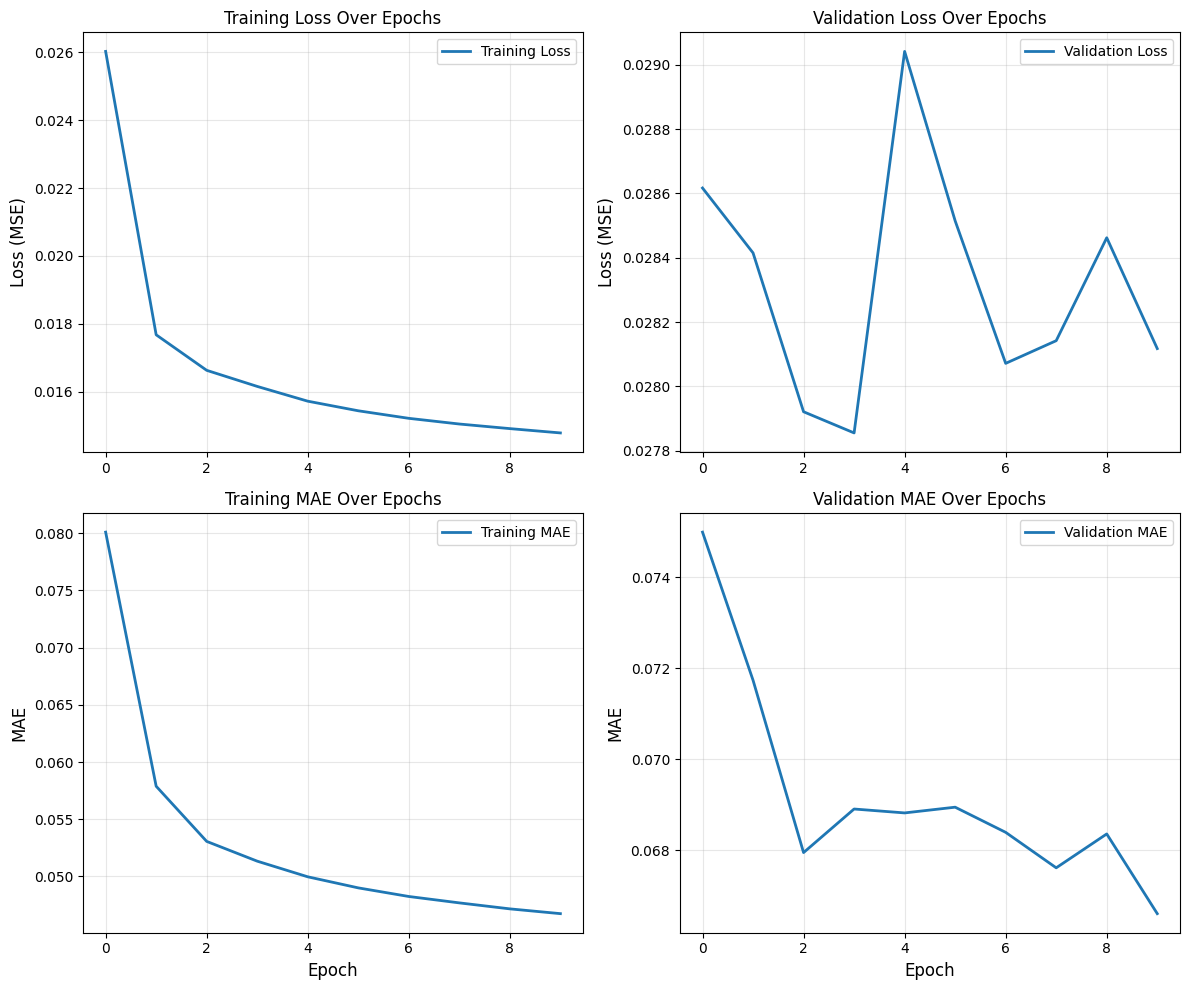

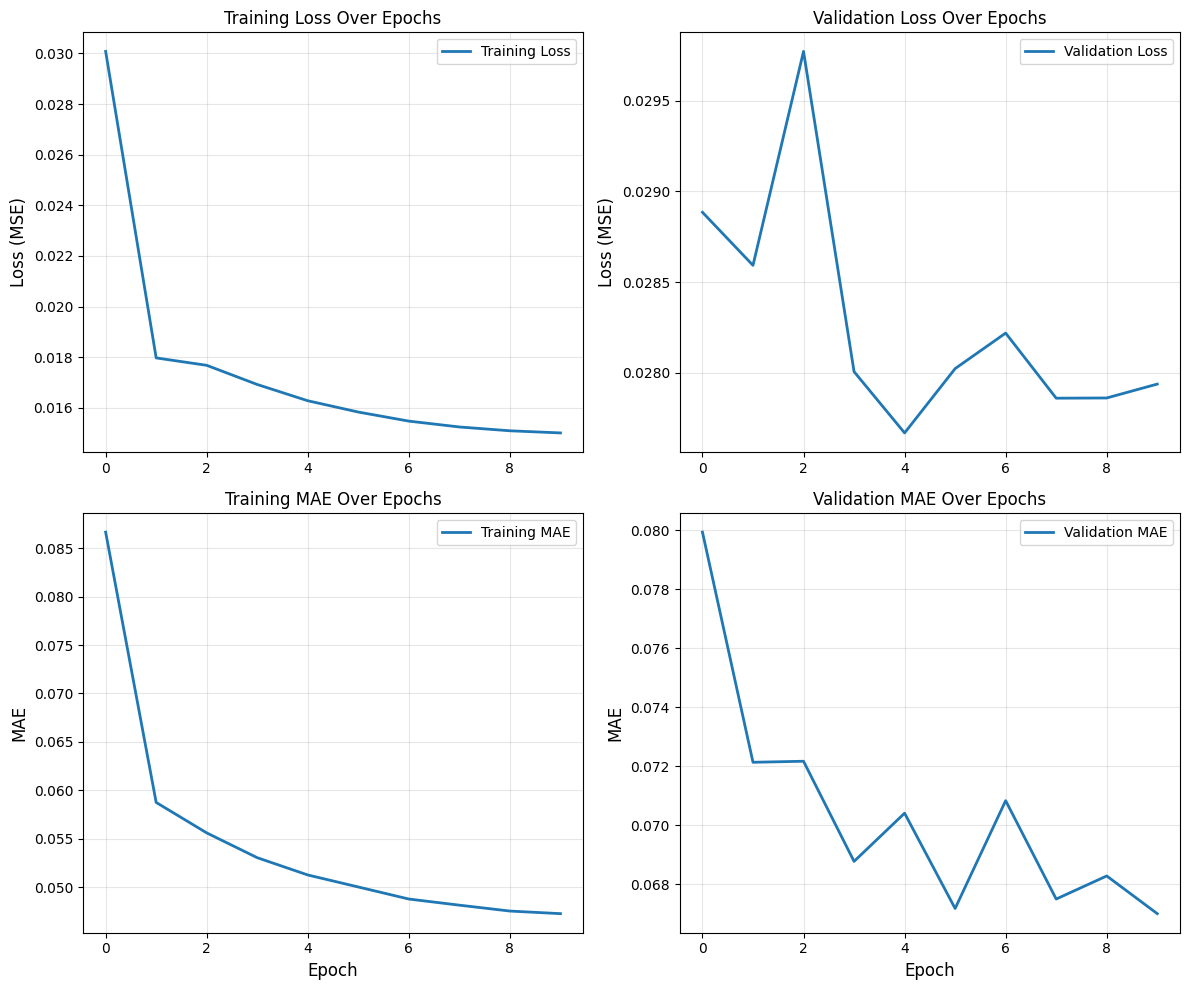

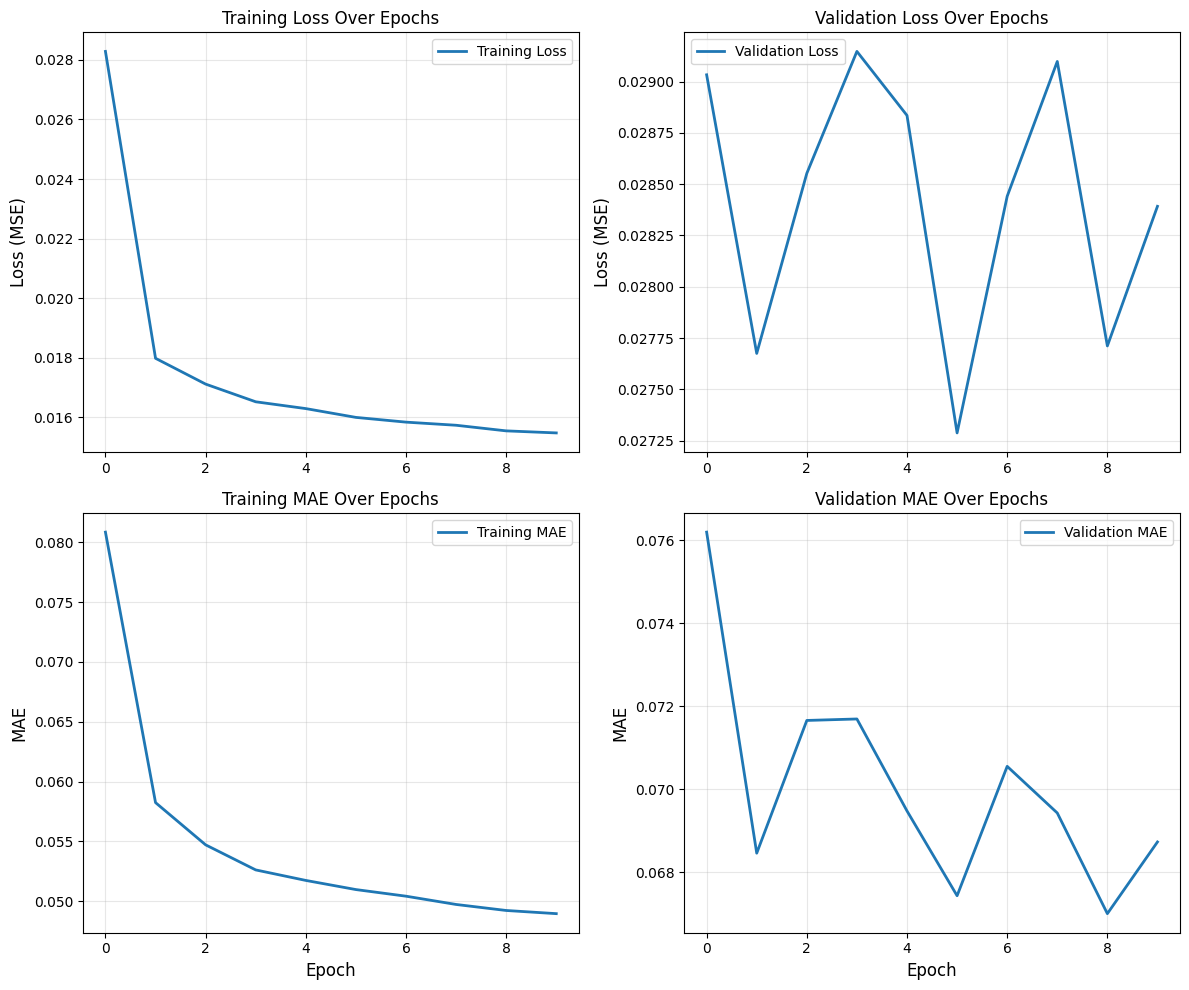

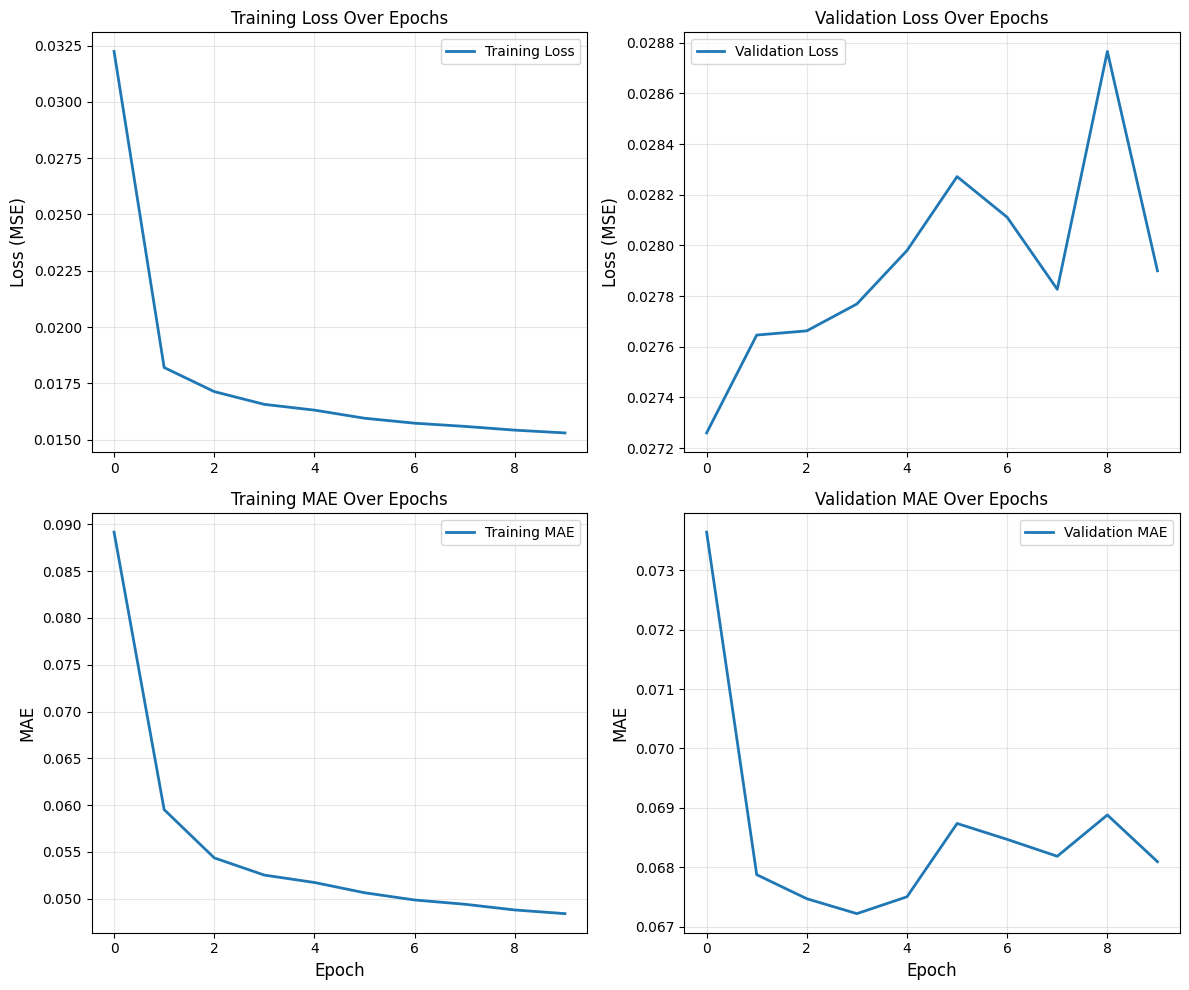

In [ ]:
# Multiple RNN training

# (lstm, dense)
params_tuples = [
    (128, 64),
    (128, 32),
    (64, 64),
    (64, 32),
]

for lstm_neurons, dense_neurons in params_tuples:

    print("-"*50)
    print(f"TRAINING WITH {lstm_neurons} LSTMS AND {dense_neurons} IN DENSE")
    print("-"*50)
    model = keras.Sequential()
    # Add an Embedding layer expecting input vocab of size 1000, and
    # output embedding dimension of size 64.
    # model.add(layers.Embedding(input_dim=1000, output_dim=64)) # Embedding layer is not needed for this task

    model_name = f"lstm{lstm_neurons}tanh_{dense_neurons}relu_exp_1401"

    model = keras.Sequential([
        layers.LSTM(lstm_neurons, input_shape=(None, 15), activation='tanh', return_sequences=False),
        layers.Dense(dense_neurons, activation='relu'),
        layers.Dense(9)  # [Kp, Ki, Kd]
    ])

    model.summary()

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mse',  # Mean Squared Error is a common loss function for regression tasks
                  metrics=['mae']) # Mean Absolute Error is another useful metric for regression

    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print(model(X[:1]).shape)

    # Train the model
    # You can adjust the number of epochs and batch size as needed
    history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.4)
    model.save(f"/content/drive/MyDrive/pid_autotuning/models/{model_name}.h5")

    print("Training complete.")

    # ===== VISUALIZATION AND EVALUATION =====
    print("\n" + "="*50)
    print("TRAINING METRICS AND EVALUATION")
    print("="*50 + "\n")

    # Create a figure with 4 subplots
    plt.figure(figsize=(12, 10))

    # 1. Top Left: Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.title('Training Loss Over Epochs')
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # 2. Top Right: Validation Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Validation Loss Over Epochs')
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # 3. Bottom Left: Training MAE
    plt.subplot(2, 2, 3)
    plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
    plt.title('Training MAE Over Epochs')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # 4. Bottom Right: Validation MAE
    plt.subplot(2, 2, 4)
    plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    plt.title('Validation MAE Over Epochs')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/pid_autotuning/models/{model_name}_training_history.png', dpi=300, bbox_inches='tight')

    # 3. Final Training Metrics Summary
    print("\n" + "-"*50)
    print(f"FINAL TRAINING METRICS FOR {model_name} MODEL")
    print("-"*50)
    print(f"Final Training Loss:      {history.history['loss'][-1]:.6f}")
    print(f"Final Validation Loss:    {history.history['val_loss'][-1]:.6f}")
    print(f"Final Training MAE:       {history.history['mae'][-1]:.6f}")
    print(f"Final Validation MAE:     {history.history['val_mae'][-1]:.6f}")

    # 4. Make predictions on validation data
    split_idx = int(len(X) * 0.8)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    y_pred = model.predict(X_val)

    # 5. Calculate per-parameter metrics
    print("\n" + "-"*50)
    print("PER-PARAMETER EVALUATION (on validation set)")
    print("-"*50)
    param_names = ['Kp_motor0', 'Ki_motor0', 'Kd_motor0',
                  'Kp_motor1', 'Ki_motor1', 'Kd_motor1',
                  'Kp_motor2', 'Ki_motor2', 'Kd_motor2']

    for i, param_name in enumerate(param_names):
        mae = np.mean(np.abs(y_val[:, i] - y_pred[:, i]))
        mse = np.mean((y_val[:, i] - y_pred[:, i])**2)
        rmse = np.sqrt(mse)
        print(f"{param_name:12s} - MAE: {mae:.6f}, RMSE: {rmse:.6f}")